In [1]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time

#I/O 

now_path            =   '../BRILLOUIN/TDP43/ARS_13_02/'
spectra_filename    =   'ARS_13_02'
VIPA_filename       =   'NO_ARS_13_02_VIPA_quasisat.tif'
log_file            =   'log_'+spectra_filename
analysis_dir       =   'analysis_best/'

#operatives

syg_kwargs          =   {'height': 80, 'distance': 31, 'width': 3.}
syg_kwargs_VIPA     =   {'distance':70, 'width': 1}
syg_kwargs_brill    =  {'height': 20, 'distance': 31, 'width': 3.}
VIPA_treshold       =   6
sat_height          =   50000
sat_width           =   13.5

cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position',  'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')

ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat


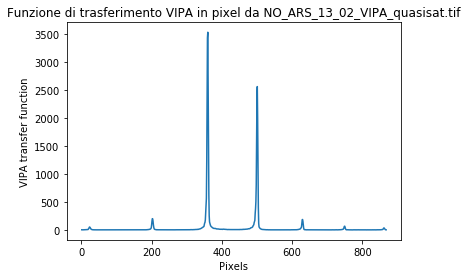

Text(0.5, 1.0, '(66, 3)')

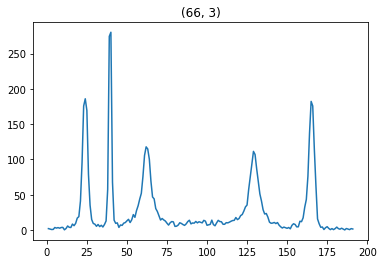

In [9]:
#0) importo dati e inizializzo oggetti
i   =   66
j   =   3
y    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y3')[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = False, cut_range = (10, 175))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = 'VIPA_img', save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.title(str((i,j)))

In [ ]:

check = Data.Check_Spectrum_Saturation(saturation_height = sat_height, saturation_width = sat_width)

if      check == 1  : nature    = 'saturo'
elif    (Data.n_peaks == 2) :

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    if (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][1]]) & (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][3]]):
        nature    = 'brillouin_highest_dx'
    elif (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][2]]) & (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][0]]):
        nature    = 'brillouin_highest_sx'
    else:
        raise ValueError ('Non ho riconosciuto lo spettro\n')

elif (Data.n_peaks == 3) :
    Data.Get_Spectrum_Peaks(**syg_kwargs_brill) 
    nature = 'brillouin_higher'
else:                 nature    = 'bono'
print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))
plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks['idx']], Data.y[Data.peaks['idx']], '*')
plt.title(str((i,j)))

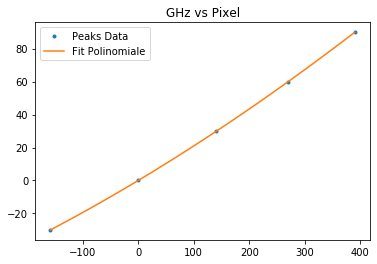

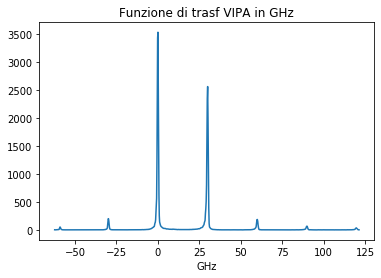

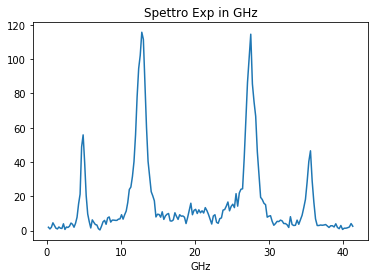



Ho stimato 11 parametri iniziali per il fit che andrai a fare

Co  = 0.100 

Omega  = 7.357 

Gamma  = 0.100 

delta_position  = 0.000 

delta_width  = 0.050 

delta_amplitude  = 0.100 

A  =  nan 

mu  =  nan 

sigma  =  nan 

shift  = 0.000 

offset  = 0.000 



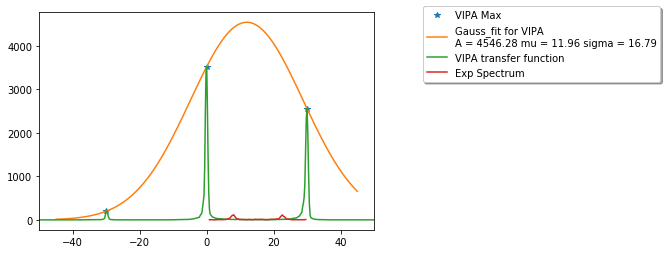

In [3]:
#1) Operazioni di modifica Spettro

Data.How_Many_Peaks_To_VIPA(treshold = VIPA_treshold, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)

if nature == 'brillouin_higher':
        Data.Get_Spectrum_Peaks(**syg_kwargs_brill)

Data.Spectrum_Pix2GHz(fig = True)
Data.Align_Spectrum()
Data.Cut_n_Estimate_Spectrum(estimate = True, cut = True, verbose = True, distanza = .25)
Data.Fit_VIPA_Gaussian(fig = True)


Text(0.5, 1.0, 'Spectrum ready for fit (39, 1)')

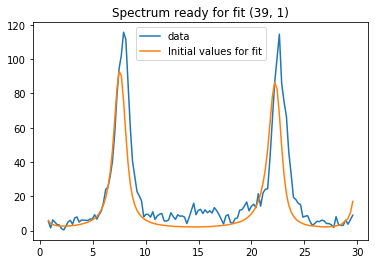

In [4]:
plt.figure()
plt.plot(Data.x_freq, Data.y, label = 'data')
#plt.plot(Data.x_freq, Data.Gauss_Convolve_Markovian_Response_Fast(Data.p0[list(cols_mark)].values[0]), label = 'initial fit')
plt.plot(Data.x_freq, Data.Gauss_Convolve_Markovian_Response_Fast(np.array([0.08,7.65873607e+00,1.82324546e-01, 0., 0.05, 0.01, 6.22635499e+02, 1.08517836e+01 ,1.67069448e+01, 0.00000000e+00, 0])), label = 'Initial values for fit')
plt.legend()
plt.title('Spectrum ready for fit {}'.format(Data.name))

In [5]:
print(Data.p0[list(cols_mark)].values[0], sep = ',')
Data.p0[list(cols_mark)]


[1.00000000e+00 7.35729876e+00 1.00000000e-01 0.00000000e+00
 5.00000000e-01 1.00000000e+00 4.54628218e+03 1.19622722e+01
 1.67908016e+01 0.00000000e+00 0.00000000e+00]


,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Initials,1,7.357299,0.1,0.0,0.5,1.0,4546.282185,11.962272,16.790802,0.0,0




 Ho trovato 2 picchi nel tuo spettro sperimentale con le caratteristiche richieste
 Altezza > 88.00 
 Spessore > 1.00 



 Il picco 1 ha: 	 indice = 46 	 x_value (pix) = 62.00 	 ampiezza(pix) = 6.94 	 altezza = 115.71 


 Il picco 2 ha: 	 indice = 114 	 x_value (pix) = 130.00 	 ampiezza(pix) = 6.58 	 altezza = 114.57 



{'n_peaks': 2,
 'idx': array([ 46, 114]),
 'peaks_width': array([6.9432815 , 6.58392327]),
 'peak_heights': array([115.71428571, 114.57142857])}

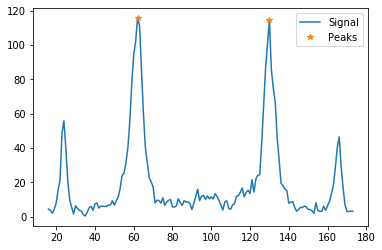

In [6]:
Analyze_Peaks(Data.x, Data.y, 'pix', height = 88, distance = 35, width = 1., verbose = True, fig = True)
#plot(Data.peaks

Cost before fitting = 3998.4424686247276
s impiegati a fare il fit  25.655354792999997 

Cost after fitting = 91.6629937842371

                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.092811  7.591378  0.192573       -0.402083     0.005492   
StdErrs   0.056704  0.022589  0.015124        0.022259     0.004267   
Initials  0.100000  7.357299  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.011600  4.501121e+03  11.593458  14.971511  0.374814   
StdErrs          0.008815  7.830986e+09   4.465838  11.950252  0.022217   
Initials         0.100000  4.546282e+03  11.962272  16.790802  0.000000   

            offset  
Values    1.737161  
StdErrs   0.388658  
Initials  0.000000  
Valore stimato della cost function prima del fit totale con fit markoviano:
91.6629937842371


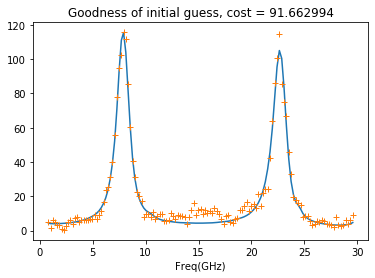

In [5]:
#3) fit markoviano
percents        =   ('positive', 0.2, 'positive', np.inf, 'positive', 'positive', 0.5, 0.5, 0.5,  np.inf, np.inf)
Data.Get_p0(Data.p0.values[0], cols_mark)
Data.Get_cost_markov(Data.p0.values[0])
print('Cost before fitting = {}'.format(Data.cost_markov))
Data.Get_Fit_Bounds(percents, cols_mark)
#_= Data.Non_Linear_Least_Squares_Markov(max_nfev = 100)
_ = Data.Non_Linear_Least_Squares_Markov(bound = (Data.bounds['down'].values, Data.bounds['up'].values),  max_nfev = 500)
Data.Get_cost_markov(Data.Markov_Fit_Params.values[0])
print('Cost after fitting = {}\n'.format(Data.cost_markov))
print(Data.Markov_Fit_Params)
Data.Take_A_Look_Before_Fitting()

In [8]:
Data.bounds

,down,up
Co,-1.500000,1.500000
Omega,-1.500000,1.500000
Gamma,-1.500000,1.500000
delta_position,-1.500000,1.500000
delta_width,0.000000,inf
delta_amplitude,0.000000,inf
A,2273.141092,6819.423277
mu,5.981136,17.943408
sigma,8.395401,25.186202
shift,-inf,inf


Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2743e+02                                    2.17e+00    
       1              3         2.2697e+02      4.57e-01       3.39e+00       1.00e+01    
       2              5         2.2693e+02      4.50e-02       1.68e+00       4.98e+01    
       3             11         2.2688e+02      4.94e-02       1.64e-03       1.07e+01    
       4             13         2.2687e+02      2.72e-03       3.95e-04       1.83e+00    
       5             14         2.2687e+02      7.88e-04       1.83e-04       1.43e+00    
       6             15         2.2687e+02      1.26e-03       1.79e-04       1.26e+00    
       7             16         2.2687e+02      1.69e-03       3.82e-04       3.89e+00    
       8             17         2.2687e+02      1.52e-03       4.11e-04       4.42e+00    
       9             19         2.2687e+02      3.92e-04       3.53e-04       3.18e+00    
  

2

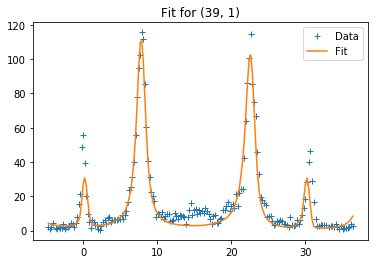

In [16]:
#4) fit totale
percents                    =   (0.2, 0.1, 0.1, 'positive', 'positive', 0.15, 0.15, 0.15, np.inf, np.inf)
Data.Initials_Parameters_from_Markov(Data.Markov_Fit_Params.T['Values'].values)
Data.Get_Fit_Bounds(percents, columns = cols_real)
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]
Data.Get_p0(Data.p0[list(cols_real)].values[0], cols_real)
Data.Non_Linear_Least_Squares(p_gauss, cols_real, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 50)


In [17]:
Data.Tot_Fit_Params

,Co,Omega,Gamma,Delta,tau,delta_width,delta_amplitude,shift,offset
Values,0.096269,7.611313,0.208944,5.245806,99.608743,0.181446,0.052517,0.300591,0.015968
StdErrs,0.002784,0.110500,0.014067,45.659114,1134.925383,0.029879,0.027596,0.017534,0.266231
Initials,0.096014,7.625714,0.208693,0.208693,100.000000,0.180872,0.053514,0.297171,0.012620


In [8]:
Data.Markov_Fit_Params

,Co,Omega,Gamma,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.093418,7.590444,0.199874,0.106239,0.336764,2.442337e+03,11.574650,14.998466,0.339294,1.369535
StdErrs,0.033432,0.023207,0.014722,0.004138,0.078594,3.817214e+09,2.671525,6.903077,0.001247,0.337767
Initials,1.000000,7.357299,0.100000,0.500000,1.000000,4.546282e+03,11.962272,16.790802,0.000000,0.000000


In [ ]:
np.concatenate((Data.Markov_Fit_Params.T['Values'].values[:3], (Data.p0['Gamma']['Values'], 1.), Data.Markov_Fit_Params.T['Values'].values[3:]))

In [ ]:
p = np.array([0.1, 7.56805159e+00, 6.19038359e-01, 6.19038359e-01,
       1.00000000e-01, 5.00000000e-01, 1.00000000e+00, 6.22635499e+02,
       0, 1.67069448e+01])

fantoccio = False;(-50, 70)
if fantoccio :

    conv_range = np.linspace(fantoccio[0], fantoccio[1], 200)

else:
    
    conv_range = Data.x_freq

Data.y_markov_convolution      =       np.zeros(conv_range.size)
w_j_VIPA                       =       np.linspace(-35,35, Data.x_VIPA_freq.size)
kernel                         =       Data.Interpolate_VIPA(w_j_VIPA)
plt.figure
plot(w_j_VIPA, kernel)
kernel                         =       kernel/(p[5]*(np.exp(-((w_j_VIPA-p[6])**2)/(2*(p[7]**2)))))

for  ii in range(len(conv_range)):

    delta_w                         =   conv_range[ii] -   w_j_VIPA
    theor                           =   S_Dynamical_Form_Factor_0(delta_w-p[8], *p[0:5])
    Data.y_markov_convolution[ii]   =   np.sum(theor*kernel)
plt.figure()
plot(Data.x_freq, Data.y)

plot(conv_range, Data.y_markov_convolution)

In [ ]:
Data.y_markov_convolution      =       np.zeros(Data.x_freq.size)
_ , idx_min             =       Find_Nearest(Data.x_VIPA_freq, -35.)
_ , idx_max             =       Find_Nearest(Data.x_VIPA_freq, 35.)
w_j_VIPA                =       Data.x_VIPA_freq[idx_min:idx_max]#-1 per azzeccare dim coi bins
VIPA_w_j                =       Data.y_VIPA[idx_min:idx_max-1]
Delta_w_j_VIPA          =       Get_Delta_Between_Array_Elements(w_j_VIPA)
w_j_VIPA                =       w_j_VIPA[:w_j_VIPA.size-1]
kernel                  =       VIPA_w_j*Delta_w_j_VIPA/(p[5]*(np.exp(-((w_j_VIPA-p[6])**2)/(2*(p[7]**2)))))

for  ii in range(len(Data.x_freq)):

    delta_w                 =   Data.x_freq[ii] -   w_j_VIPA
    theor                   =   S_Dynamical_Form_Factor_0(delta_w-p[8], *p[0:5])
    Data.y_markov_convolution[ii]  =   np.sum(theor*kernel)

Data.y_Gauss_markov_convolution   =   p[9] + Data.y_markov_convolution*p[5]*np.exp(-((Data.x_freq - p[6])**2)/(2*(p[7]**2)))
plt.figure()
plot(Data.x_freq, Data.y)

plot(Data.x_freq, Data.y_markov_convolution)


In [ ]:
p0 = Data.p0.values[0]
Data.Get_p0(p0, cols_mark)
Data.p0.values[0]
Data.p0